In [338]:
import requests
import re

import folium
import geopandas as gpd

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from selenium.webdriver.common.by import By
from selenium import webdriver
from bs4 import BeautifulSoup
from branca.colormap import linear
import branca.colormap as cm

## 1. Парсинг данных через API и Selenium

В данном проекте будет использован API Поиска по организациям Яндекс Карт 

Инструкция по получению ключа для api: 
   1. Перейти по ссылке https://yandex.ru/dev/maps/geosearch/?from=mapsapi
   2. Нажать "Получить ключ" 
   3. Заполнить контактные данные (Цель: учебный проект)
   4. Скопировать ключ в переменную ниже
   
Функция ниже отправляет запрос на поиск мест в яндекс картах. Запрос состоит из названия места place и региона поиска region. На выходе функция выдает pandas.DataFrame с адресом и регионом найденных по запросу мест

In [131]:
def yandex_maps_api(api_key, place, region):
    
    # Создаем пустой pandas.DataFrame в котором будем хранить данные
    # Колонки: Place - название кафе
    #          Adress - Адрес
    #          Region - Регион
    
    df = pd.DataFrame(columns = ['Place', 'Address', 'Region']) 
    url = 'https://search-maps.yandex.ru/v1/'
    search_request = f'{place} {region}'
    i=0
    
    while True:
        params = {'apikey': api_key, 'text': search_request, 'lang': 'ru_RU',
                 'results':50, 'skip':50*i}
        data = requests.get(url, params = params)
    
        info = data.json()
        
        if len(info['features'])==0:
            break
        
        temp_df = pd.DataFrame()
        place_col, city_col, reg_col = [], [], []
        for place in info['features']:
            place_col.append(place['properties']['name'])
            try:
                city_col.append(place['properties']['CompanyMetaData']['address'])
                reg_col.append(place['properties']['CompanyMetaData']['address'].split(',')[0])
            except KeyError:
                city_col.append('Закрыто')
                reg_col.append('Закрыто')
        
        temp_df['Place'] = place_col
        temp_df['Address'] = city_col
        temp_df['Region'] = reg_col
        #temp_df['Requested_region'] = [region]*len(temp_df)

        df = df.append(temp_df)
        i+=1
        if i==200: # ограничение Api
            break 
    
    return df

Кроме того спарсим через Selenium названия регионов с сайта Росстата ('https://www.gks.ru/bgd/regl/b04_42/IssWWW.exe/Stg/d010/i011830r.htm'). Полученные значения обработаем с помощью регулярных выражений

In [128]:
def parse_region_names(browser): # Ввести браузер

    ref = 'https://www.gks.ru/bgd/regl/b04_42/IssWWW.exe/Stg/d010/i011830r.htm'
    browser.get(ref)
    element = browser.find_element(by=By.CSS_SELECTOR, value="table")
    text = element.text
    browser.quit()
    
    regions = re.findall(r'\d\. [^\n]+', text)
    
    new_regions = []

    for region in regions:
        if re.match(r'.*округ', region) == None and re.match(r'.*числе', region) == None :
            new_regions.append(region.split('. ')[-1].rstrip())
            
    return new_regions[1:]

In [133]:
# Ключ доступа к API
api_key = '0d5460b6-5fd3-45b4-884f-19307eb88920'

In [129]:
# Получим список регионов
browser = webdriver.Safari() # Поменяйте переменую браузер на свой при необходимости
list_of_regions = parse_region_names(browser)
print(list_of_regions[:5])

['Белгородская область', 'Брянская область', 'Владимирская область', 'Воронежская область', 'Ивановская область']


**Обратите внимание, что  API позволяет парсить значения по запросу по 50 штук за запрос. Поэтому функционал реализовается через циклы и счетчик (переменная skip в словаре params). В случае запуска кода, для парсинга всех мест по всем регионом количество обращений будет превышать допустимый лимит. Поэтому сначала для тестирования работы кода сначала запустите тесты с одиночными запросами, а затем (при необходимости) финальный.**

In [136]:
# Одиночные запрос для тестирования кода. Можно поменять значения на свои

place = 'Аэропорт'
region = 'Москва'
test_df = yandex_maps_api(api_key, place, region)
test_df.head()

**Внимание! Запускать в последнюю очередь**

In [72]:
df = pd.DataFrame()
places = ['Вкусно — и точка', 'Бургер Кинг', 'KFC', 'Теремок']
for place in places:
    for region in list_of_regions:
        df = df.append(yandex_maps_api(api_key, place, region))
        
df.reset_index(drop=True, inplace=True)

In [73]:
# Сохраняем полученный датасет, так как для повтора запроса приходится содавать новый ключ
#df.to_csv('FastFoodRussian.csv', index=False)

## 2. Предобработка полученных данных

В функции было реализован сбор Адреса места, чтобы в дальнейшем отбросить повторы. Например адрес повторяется, а названия: "Вкусно - и точка" и "Вкусно - и точка Авто".

Кроме того API Яндекс Карт работает с квадратным окном поиска. Поэтому в некоторых ситуациях могли попасть несколько одинаковых ресторанов но по запросу от разных регионов. Их также фильтруем по адресу
Также попали, поэтому могли попасть удивительные места вне России. Встречаались примеры с Казахстаном (логично) и даже Францией. Их отбросим отфильтровав регионы по нашему списку.

Помимо этого было обнаружено что если ресторан находился в столице региона, то его адрес был, например, не "Смоленская область, Смоленск...", а "Смоленск, ..." поэтому спарсим также столицы регионов и сделаем словарь из полученных пар, а затем поменяем столицы в поле Region на названия регионов

Также по запросу выдавались не только перечисленные места, но и похожие. Их тоже надо отбросить

In [259]:
df = pd.read_csv('FastFoodRussian.csv')

In [260]:
df.drop_duplicates(subset = 'Address', inplace = True)
df = df[df['Place'].isin(places)]

In [261]:
def parse_region_capitals():
    
    page = requests.get('https://ru.wikipedia.org/wiki/Субъекты_Российской_Федерации').text
    soup = BeautifulSoup(page, 'html.parser')
    table = soup.find('table', class_="standard sortable")

    df = pd.read_html(str(table))
    df = pd.concat(df)
    df = df[['Адм. центр/столица','Субъект Российской Федерации']]
    df = df.dropna()
    df['Субъект Российской Федерации'] = [re.findall(r'[^0-9\[\]]*', i)[0] for i in df['Субъект Российской Федерации']]
    
    d = {}
    for key, value in zip(df['Адм. центр/столица'], df['Субъект Российской Федерации']):
        d.update({key : value})
    return(d)

In [262]:
capital_dict = parse_region_capitals()

In [263]:
new_regions = []

for reg in df['Region']:
    try:
        new_regions.append(capital_dict[reg])
    except KeyError:
        new_regions.append(reg)

In [264]:
df['Region1']=new_regions
df.head(10)

,Place,Address,Region,Region1
0,Вкусно — и точка,"Свердловская область, Екатеринбург, улица Малы...",Свердловская область,Свердловская область
1,Вкусно — и точка,"Самара, Полевая улица, 15",Самара,Самарская область
2,Вкусно — и точка,"Белгород, Белгородский проспект, 87",Белгород,Белгородская область
3,Вкусно — и точка,"Белгород, проспект Богдана Хмельницкого, 160А",Белгород,Белгородская область
4,Вкусно — и точка,"Белгородская область, Старый Оскол, микрорайон...",Белгородская область,Белгородская область
5,Вкусно — и точка,"Белгород, улица Щорса, 64",Белгород,Белгородская область
8,Вкусно — и точка,"Белгород, проспект Богдана Хмельницкого, 137Т",Белгород,Белгородская область
12,Вкусно — и точка,"Брянск, Бежицкая улица, 2В",Брянск,Брянская область
13,Вкусно — и точка,"Брянск, улица Ульянова, 1В",Брянск,Брянская область
15,Вкусно — и точка,"Брянск, улица 3 Интернационала, 8А",Брянск,Брянская область


In [266]:
df = df[df['Region'].isin(list_of_regions)]

## 3. Анализ данных

Выведем топ-10 по парам регион-кафе

In [267]:
df.groupby(by=['Region', 'Place']).count().sort_values(by='Address', ascending=False)[:10]

Address  Region1
Region             Place                             
Москва             Вкусно — и точка      196      196
                   KFC                   124      124
                   Бургер Кинг           119      119
Санкт-Петербург    Теремок                97       97
Московская область Бургер Кинг            90       90
                   Вкусно — и точка       83       83
Санкт-Петербург    Вкусно — и точка       76       76
Москва             Теремок                61       61
Московская область KFC                    60       60
Санкт-Петербург    KFC                    58       58

Функция для построения топ n регионов по кол-ву точек фастфуда

In [255]:
def distribution_by_region(df, n):
    
    data = df.groupby(by='Region', as_index=False).count()
    
    print(f'Топ {n} регионов по кол-ву точек фастфуда\n')
    
    if n > len(df['Region'].unique()):
        n = len(df['Region'].unique())
    
    for reg, count in zip(data.sort_values(by='Place', ascending=False)['Region'][:n], 
                          data.sort_values(by='Place', ascending=False)['Place'][:n]):
        print(f'{reg} - {count}')
        
    

In [256]:
distribution_by_region(df, 10)

Топ 10 регионов по кол-ву точек фастфуда

Москва - 500
Санкт-Петербург - 283
Московская область - 265
Краснодарский край - 93
Свердловская область - 89
Республика Татарстан - 77
Республика Башкортостан - 72
Алтайский край - 44
Нижегородская область - 41
Приморский край - 37


Построим также barplot распределения для топ 20 регионов

Text(0, 0.5, 'Number of places')

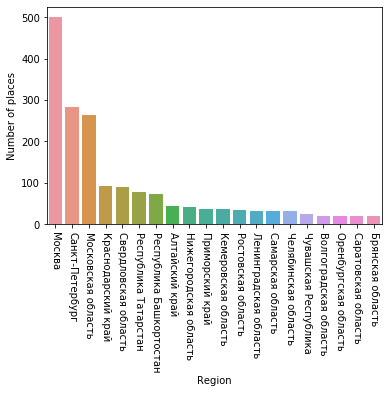

In [257]:
sns.barplot(data = df.groupby(by='Region', as_index=False).count()\
            .sort_values(by='Place', ascending=False)[:20], x = 'Region', y = 'Place')

plt.xticks(rotation=-90)
plt.ylabel('Number of places')

#plt.savefig('Fig1.jpeg')

Аналогичный график построим для распределния точек сети

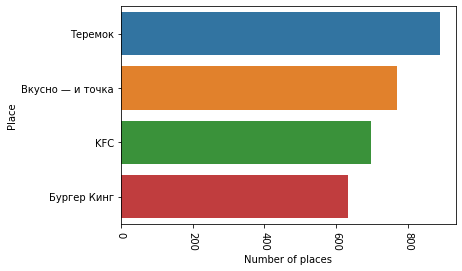

In [265]:
sns.barplot(data = df.groupby(by='Place', as_index=False).count()\
            .sort_values(by='Region', ascending=False), x = 'Region', y = 'Place')

plt.xlabel('Number of places')
plt.xticks(rotation=-90)
#plt.savefig('Fig2.jpeg')

Интересно! Видимо пока иностранные сети фаст-фуда уходят, "Теремок" расширяется

Теперь найдем регионы которые любят определенные сети фастфуда больше других. Посчитаемое процентное соотношение тех или иных сетей по кааждому региону, а затем отобразим это на карте

In [270]:
grouped_df = df.groupby(by=['Region','Place'], as_index=False).count()
grouped_df.head()

,Region,Place,Address,Region1
0,Алтайский край,KFC,6,6
1,Алтайский край,Бургер Кинг,7,7
2,Алтайский край,Вкусно — и точка,3,3
3,Алтайский край,Теремок,28,28
4,Амурская область,KFC,2,2


In [287]:
pivot = pd.pivot_table(grouped_df, values='Address', index='Region',
                        columns='Place')
pivot.fillna(0, inplace=True)
pivot.head()

Place,KFC,Бургер Кинг,Вкусно — и точка,Теремок
Region,,,,
Алтайский край,6.0,7.0,3.0,28.0
Амурская область,2.0,0.0,0.0,7.0
Архангельская область,1.0,0.0,1.0,0.0
Астраханская область,0.0,0.0,0.0,3.0
Белгородская область,1.0,3.0,1.0,8.0


In [288]:
# Для удобства дальнейшего пересчета процента
pivot.reset_index(inplace = True)

In [289]:
pivot.columns

Index(['Region', 'KFC', 'Бургер Кинг', 'Вкусно — и точка', 'Теремок'], dtype='object', name='Place')

In [299]:
def favourite(df):
    
    df['Sum'] = [i+j+k+m for i,j,k,m in zip(df['KFC'], df['Бургер Кинг'], df['Вкусно — и точка'], df['Теремок'])]
    
    for col in df.columns[1:]:
        df[f'Percent_{col}'] = [np.round(i/j*100,2) for i,j in zip(df[col], df['Sum'])]
    
    
    for place in ['KFC', 'Бургер Кинг', 'Вкусно — и точка', 'Теремок']:
        print(f'Топ 5 регионов по проценту точек {place}\n')
        for reg, percent in zip(df.sort_values(by=f'Percent_{place}', ascending=False)['Region'][:5], 
                          df.sort_values(by=f'Percent_{place}', ascending=False)[f'Percent_{place}'][:5]):
            print(f'{reg} - {percent}')
        
        print('\n')
        
    return df
    

In [300]:
new_df = favourite(pivot)

Топ 5 регионов по проценту точек KFC

Республика Ингушетия - 100.0
Карачаево-Черкесская Республика - 75.0
Архангельская область - 50.0
Республика Дагестан - 50.0
Приморский край - 45.95


Топ 5 регионов по проценту точек Бургер Кинг

Республика Алтай - 50.0
Вологодская область - 37.5
Московская область - 33.96
Тюменская область - 33.33
Удмуртская Республика - 33.33


Топ 5 регионов по проценту точек Вкусно — и точка

Республика Алтай - 50.0
Архангельская область - 50.0
Республика Адыгея - 44.44
Ярославская область - 42.86
Москва - 39.2


Топ 5 регионов по проценту точек Теремок

Костромская область - 100.0
Еврейская автономная область - 100.0
Республика Калмыкия - 100.0
Рязанская область - 100.0
Курганская область - 100.0




In [293]:
new_df.head()

Place,Region,KFC,Бургер Кинг,Вкусно — и точка,Теремок,Sum,Percent_KFC,Percent_Бургер Кинг,Percent_Вкусно — и точка,Percent_Теремок,Percent_Sum
0,Алтайский край,6.0,7.0,3.0,28.0,44.0,13.64,15.91,6.82,63.64,100.0
1,Амурская область,2.0,0.0,0.0,7.0,9.0,22.22,0.00,0.00,77.78,100.0
2,Архангельская область,1.0,0.0,1.0,0.0,2.0,50.00,0.00,50.00,0.00,100.0
3,Астраханская область,0.0,0.0,0.0,3.0,3.0,0.00,0.00,0.00,100.00,100.0
4,Белгородская область,1.0,3.0,1.0,8.0,13.0,7.69,23.08,7.69,61.54,100.0


Теперь построим карты где цветом будет обозначен процент присутствия фастфуда той или иной сети, а также общее кол-во точек фастфуда. Строить будем с помощью folium и geopandas.

Датасеты с геометрическими границами регионов и код для вдохновения был взят с (https://www.kaggle.com/code/kapral42/covid-19-russia-geo-plotting)

In [303]:
rus_info_df = pd.read_csv('regions-info.csv')
rus_info_df.head()

,Region_ID,Region,Region_eng,Population,Rus_perc,Urban_pop,Urban_pop_perc,Rural_pop,Rural_pop_perc,Area,Density_pop_sqkm,Federal_district,Latitude,Longitude
0,0,Россия,Russia,146745098,100,109326899,"74,5",37553533,"25,59",17125191,"8,57",РФ,64.686314,97.745306
1,77,Москва,Moscow,12692466,"8,65",12342615,"97,24",163853,"1,29",2561,"4956,06",ЦФО,55.479205,37.327330
2,50,Московская область,Moscow region,7687647,"5,24",6123573,"79,65",1379812,"17,95",44329,"173,42",ЦФО,55.504316,38.035393
3,23,Краснодарский край,Krasnodar region,5677786,"3,87",3075168,"54,16",2528252,"44,53",75485,"75,22",ЮФО,45.768401,39.026104
4,78,Санкт-Петербург,St. Petersburg,5392992,"3,68",5351935,"99,24",0,0,1403,"3843,9",СЗФО,59.960674,30.158655


Как видно, мы потеряли часть регионов. Либо яндекс не обработал запрос, либо дейстивтельно в них нет ресторанов данных сетей. Добавим их с 0 во всех значениях

In [311]:
for region in list_of_regions[1:]:
    if region not in list(new_df['Region']):
        print(region)
        new_df.loc[len(new_df.index), 'Region'] = region
        
new_df.fillna(0, inplace=True)

Республика Северная Осетия - Алания
Пермская область
Ханты-Мансийский автономный
Ямало-Ненецкий
Читинская область
Камчатская область
Магаданская область


In [318]:
right = rus_info_df[['Region', 'Population', 'Latitude', 'Longitude']]
rus_geo_df = right.merge(new_df, left_on='Region', right_on='Region', how='left')

In [319]:
rus_info_df

,Region_ID,Region,Region_eng,Population,Rus_perc,Urban_pop,Urban_pop_perc,Rural_pop,Rural_pop_perc,Area,Density_pop_sqkm,Federal_district,Latitude,Longitude
0,0,Россия,Russia,146745098,100,109326899,"74,5",37553533,"25,59",17125191,"8,57",РФ,64.686314,97.745306
1,77,Москва,Moscow,12692466,"8,65",12342615,"97,24",163853,"1,29",2561,"4956,06",ЦФО,55.479205,37.327330
2,50,Московская область,Moscow region,7687647,"5,24",6123573,"79,65",1379812,"17,95",44329,"173,42",ЦФО,55.504316,38.035393
3,23,Краснодарский край,Krasnodar region,5677786,"3,87",3075168,"54,16",2528252,"44,53",75485,"75,22",ЮФО,45.768401,39.026104
4,78,Санкт-Петербург,St. Petersburg,5392992,"3,68",5351935,"99,24",0,0,1403,"3843,9",СЗФО,59.960674,30.158655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,4,Республика Алтай,Altai Republic,220140,"0,15",63214,"28,72",154849,"70,34",92903,"2,37",СФО,50.711410,86.857219
82,79,Еврейская автономная область,Jewish Autonomous Region,158381,"0,11",111415,"70,35",50599,"31,95",36271,"4,37",ДВФО,48.560161,132.277566
83,49,Магаданская область,Magadan Region,140199,"0,1",138169,"98,55",5922,"4,22",462464,"0,3",ДВФО,63.551503,154.014726
84,87,Чукотский автономный округ,Chukotka Autonomous Okrug,50726,"0,03",34795,"68,59",14553,"28,69",721481,"0,07",ДВФО,66.000647,169.490087


In [320]:
rus_geo_df = rus_geo_df.dropna()

In [321]:
### FROM: (см выше)
rus_geo_df.loc[rus_geo_df.Region == 'Москва', 'Latitude'] = 55.7522
rus_geo_df.loc[rus_geo_df.Region == 'Москва', 'Longitude'] = 37.6220
rus_geo_df.loc[rus_geo_df.Region == 'Санкт-Петербург', 'Latitude'] = 59.8917
rus_geo_df.loc[rus_geo_df.Region == 'Санкт-Петербург', 'Longitude'] = 30.2673

rus_geo_df.fillna(0, inplace=True)

In [112]:
rus_bnd_gdf = gpd.read_file('geo.json')

In [323]:
# Regions mapping
rus_gdf = gpd.GeoDataFrame(rus_geo_df, geometry=gpd.points_from_xy(rus_geo_df.Longitude, rus_geo_df.Latitude))
rus_gdf.crs = {'init': 'epsg:4326'}

rus_shape = rus_bnd_gdf[['NAME_1', 'TYPE_1', 'ID_1', 'geometry']]
rus_gdf = gpd.sjoin(rus_gdf, rus_shape, how="left", op='within')

/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  


In [111]:
def embed_map(m, file_name):
    from IPython.display import IFrame
    m.save(file_name)
    return IFrame(file_name, width='100%', height='500px')

### END FROM

In [333]:
import branca.colormap as cm

### Карта процентного соотношения кол-ва ресторанов KFC относительно других ресторанов в этом регионе по регионам России (Рыжий - max%)

In [342]:
m_1 = folium.Map(
    location=[64.0914, 101.6016],
    tiles='Stamen Toner',
    zoom_start=3
)

scale_min, scale_max = 0, 100
#colormap = linear.YlOrRd_09.scale(scale_min, scale_max, colors=['red'])
colormap = cm.LinearColormap(['yellow', 'red'],
                       vmin=0, vmax=100)

def color_mapper(id):
    row = rus_gdf[rus_gdf.ID_1 == id].reset_index()
    if len(row) == 0:
        return scale_min
    return row.Percent_KFC.iloc[0]

folium.GeoJson(
    rus_bnd_gdf,
    name='rusjson',
    style_function=lambda feature: {
        'fillColor': colormap(color_mapper(feature['properties']['ID_1'])),
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5',
        'fillOpacity': 0.9,
    }
).add_to(m_1)

embed_map(m_1, 'm_1.html')

### Карта процентного соотношения кол-ва ресторанов Вкусно - и точка относительно других ресторанов в этом регионе по регионам России (Темно-коричнеый - max%)

In [341]:
m_2 = folium.Map(
    location=[64.0914, 101.6016],
    tiles='Stamen Toner',
    zoom_start=3
)

scale_min, scale_max = 0, 100
#colormap = linear.YlOrRd_09.scale(scale_min, scale_max, colors=['red'])
colormap = cm.LinearColormap(['brown', 'green'],
                       vmin=0, vmax=100)

def color_mapper(id):
    row = rus_gdf[rus_gdf.ID_1 == id].reset_index()
    if len(row) == 0:
        return scale_min
    return row['Percent_Вкусно — и точка'].iloc[0]

folium.GeoJson(
    rus_bnd_gdf,
    name='rusjson',
    style_function=lambda feature: {
        'fillColor': colormap(color_mapper(feature['properties']['ID_1'])),
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5',
        'fillOpacity': 0.9,
    }
).add_to(m_2)

embed_map(m_2, 'm_2.html')

### Карта процентного соотношения кол-ва ресторанов Бургер Кинг относительно других ресторанов в этом регионе по регионам России (Фиолетовый - max)


In [344]:
m_3 = folium.Map(
    location=[64.0914, 101.6016],
    tiles='Stamen Toner',
    zoom_start=3
)

scale_min, scale_max = 0, 100
#colormap = linear.YlOrRd_09.scale(scale_min, scale_max, colors=['red'])
colormap = cm.LinearColormap(['red', 'blue'],
                       vmin=0, vmax=100)

def color_mapper(id):
    row = rus_gdf[rus_gdf.ID_1 == id].reset_index()
    if len(row) == 0:
        return scale_min
    return row['Percent_Бургер Кинг'].iloc[0]

folium.GeoJson(
    rus_bnd_gdf,
    name='rusjson',
    style_function=lambda feature: {
        'fillColor': colormap(color_mapper(feature['properties']['ID_1'])),
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5',
        'fillOpacity': 0.9,
    }
).add_to(m_3)

embed_map(m_3, 'm_3.html')

### Карта процентного соотношения кол-ва ресторанов Теремок относительно других ресторанов в этом регионе по регионам России (Голубой - max)

In [351]:
m_4 = folium.Map(
    location=[64.0914, 101.6016],
    tiles='Stamen Toner',
    zoom_start=3
)

scale_min, scale_max = 0, 100
#colormap = linear.YlOrRd_09.scale(scale_min, scale_max, colors=['red'])
colormap = cm.LinearColormap(['blue', 'white'],
                       vmin=0, vmax=100)

def color_mapper(id):
    row = rus_gdf[rus_gdf.ID_1 == id].reset_index()
    if len(row) == 0:
        return scale_min
    return row.Percent_Теремок.iloc[0]

folium.GeoJson(
    rus_bnd_gdf,
    name='rusjson',
    style_function=lambda feature: {
        'fillColor': colormap(color_mapper(feature['properties']['ID_1'])),
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5',
        'fillOpacity': 0.9,
    }
).add_to(m_4)

embed_map(m_4, 'm_4.html')

### Карта распространений кол-ва ресторанов фастфуд в абсолютных значениях (Темно-красный - max)

In [352]:
m_5 = folium.Map(
    location=[64.0914, 101.6016],
    tiles='Stamen Toner',
    zoom_start=3
)

scale_min, scale_max = 0, np.log(rus_gdf.Sum.max()+1)
colormap = linear.YlOrRd_09.scale(scale_min, scale_max)


def color_mapper(id):
    row = rus_gdf[rus_gdf.ID_1 == id].reset_index()
    if len(row) == 0:
        return scale_min
    return np.log(row.Sum.iloc[0]+1)

folium.GeoJson(
    rus_bnd_gdf,
    name='rusjson',
    style_function=lambda feature: {
        'fillColor': colormap(color_mapper(feature['properties']['ID_1'])),
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5',
        'fillOpacity': 0.9,
    }
).add_to(m_5)

embed_map(m_5, 'm_5.html')